In [19]:
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import psutil

device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

In [21]:
# Test scenarios
prompts = {
    "short": "What is KV caching in a sentence?",
    "long": "What is KV caching, describe it in detail, explain step by step and discuss its advantages and drawbacks."
}

max_tokens_list = [100,300,500,700,900]

In [22]:
def measure_generation_time_and_memory(prompt, use_cache, max_new_tokens, repetitions=3):
    times = []
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    for _ in range(repetitions):
        start_time = time.time()
        model.generate(**inputs, use_cache=use_cache, max_new_tokens=max_new_tokens)
        elapsed_time = time.time() - start_time

        times.append(elapsed_time)

    return np.mean(times), np.std(times)

In [ ]:
# Running the tests
results = []
for use_cache in [True, False]:
  for prompt_name, prompt in prompts.items():
    for max_tokens in max_tokens_list:
      mean_time, std_time = measure_generation_time_and_memory(prompt, use_cache, max_new_tokens=max_tokens)
      results.append({"cache": use_cache, "prompt": prompt_name, "max_tokens": max_tokens, "mean_time": mean_time, "std_time": std_time})

In [24]:
import pandas as pd

df = pd.DataFrame(results)

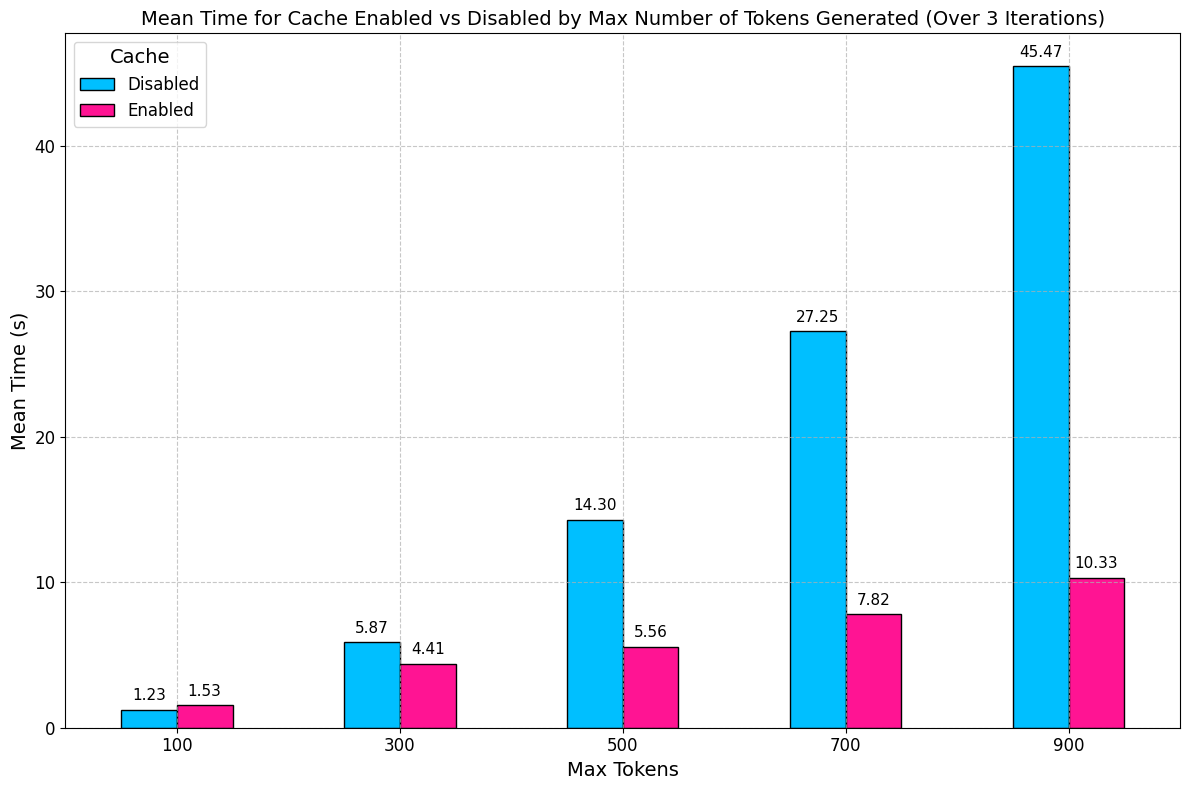

In [39]:
import pandas as pd
import matplotlib.pyplot as plt


# Grouping the data by 'max_tokens' and 'cache'
grouped = df.groupby(['max_tokens', 'cache'])['mean_time'].mean().unstack()

# Plotting
ax = grouped.plot(kind='bar', figsize=(12, 8), color=['#00BFFF', '#FF1493'], edgecolor='black')

# Customizing the plot
plt.title('Mean Time for Cache Enabled vs Disabled by Max Number of Tokens Generated (Over 3 Iterations)', fontsize=14)
plt.xlabel('Max Tokens', fontsize=14)
plt.ylabel('Mean Time (s)', fontsize=14)
plt.legend(title='Cache', labels=['Disabled', 'Enabled'], fontsize=12, title_fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Annotating bars with mean time values
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()
